# 论文2：循环神经网络的不合理有效性

## Andrej Karpathy

### 字符级语言模型与原始RNN

实现一个学习生成文本的字符级RNN。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 生成合成训练数据

In [2]:
# 带有模式的简单合成文本
data = """
hello world
hello deep learning
deep neural networks
neural networks learn patterns
patterns in data
data drives learning
learning from examples
examples help networks
networks process information
information is everywhere
everywhere you look data
""" * 10  # 重复以获得更多训练数据

# 构建词汇表
chars = sorted(list(set(data)))
vocab_size = len(chars)
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"数据长度: {len(data)} 个字符")
print(f"词汇表大小: {vocab_size}")
print(f"词汇表: {repr(''.join(chars))}")

数据长度: 2490 个字符
词汇表大小: 24
词汇表: '\n acdefghiklmnoprstuvwxy'


## 原始RNN实现

In [3]:
class VanillaRNN:
    def __init__(self, vocab_size, hidden_size):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        # 初始化权重
        self.Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(vocab_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
        
    def forward(self, inputs, hprev):
        """
        inputs: 整数列表（字符索引）
        hprev: 初始隐藏状态
        """
        xs, hs, ys, ps = {}, {}, {}, {}
        hs[-1] = np.copy(hprev)
        loss = 0
        
        # 前向传播
        for t, char_idx in enumerate(inputs):
            # 独热编码输入
            xs[t] = np.zeros((self.vocab_size, 1))
            xs[t][char_idx] = 1
            
            # 隐藏状态: h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
            hs[t] = np.tanh(
                np.dot(self.Wxh, xs[t]) + 
                np.dot(self.Whh, hs[t-1]) + 
                self.bh
            )
            
            # 输出: y_t = W_hy * h_t + b_y
            ys[t] = np.dot(self.Why, hs[t]) + self.by
            
            # Softmax概率
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
            
        return xs, hs, ys, ps
    
    def loss(self, ps, targets):
        """交叉熵损失"""
        loss = 0
        for t, target_idx in enumerate(targets):
            loss += -np.log(ps[t][target_idx, 0])
        return loss
    
    def backward(self, xs, hs, ps, targets):
        """通过时间反向传播"""
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])
        
        # 反向传播
        for t in reversed(range(len(targets))):
            # 输出梯度
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1
            
            # 输出层梯度
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            
            # 隐藏层梯度
            dh = np.dot(self.Why.T, dy) + dhnext
            dhraw = (1 - hs[t] ** 2) * dh  # tanh导数
            
            # 权重梯度
            dbh += dhraw
            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t-1].T)
            
            # 下一个时间步的梯度
            dhnext = np.dot(self.Whh.T, dhraw)
        
        # 裁剪梯度以防止梯度爆炸
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)
        
        return dWxh, dWhh, dWhy, dbh, dby
    
    def sample(self, h, seed_ix, n):
        """
        从模型采样字符序列
        h: 初始隐藏状态
        seed_ix: 种子字符索引
        n: 要生成的字符数量
        """
        x = np.zeros((self.vocab_size, 1))
        x[seed_ix] = 1
        indices = []
        
        for t in range(n):
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            
            # 从分布中采样
            ix = np.random.choice(range(self.vocab_size), p=p.ravel())
            
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            indices.append(ix)
        
        return indices

# 初始化模型
hidden_size = 64
rnn = VanillaRNN(vocab_size, hidden_size)
print(f"\n模型已初始化，包含 {hidden_size} 个隐藏单元")


模型已初始化，包含 64 个隐藏单元


## 训练循环

In [4]:
def train_rnn(rnn, data, char_to_ix, ix_to_char, num_iterations=2000, seq_length=25):
    """训练RNN"""
    n = 0  # 数据中的位置
    p = 0  # 数据指针
    
    # Adagrad的内存变量
    mWxh = np.zeros_like(rnn.Wxh)
    mWhh = np.zeros_like(rnn.Whh)
    mWhy = np.zeros_like(rnn.Why)
    mbh = np.zeros_like(rnn.bh)
    mby = np.zeros_like(rnn.by)
    
    smooth_loss = -np.log(1.0 / vocab_size) * seq_length
    losses = []
    
    hprev = np.zeros((hidden_size, 1))
    
    for n in range(num_iterations):
        # 准备输入和目标
        if p + seq_length + 1 >= len(data) or n == 0:
            hprev = np.zeros((hidden_size, 1))
            p = 0
        
        inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
        targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
        
        # 前向传播
        xs, hs, ys, ps = rnn.forward(inputs, hprev)
        loss = rnn.loss(ps, targets)
        
        # 反向传播
        dWxh, dWhh, dWhy, dbh, dby = rnn.backward(xs, hs, ps, targets)
        
        # Adagrad参数更新
        learning_rate = 0.1
        for param, dparam, mem in zip(
            [rnn.Wxh, rnn.Whh, rnn.Why, rnn.bh, rnn.by],
            [dWxh, dWhh, dWhy, dbh, dby],
            [mWxh, mWhh, mWhy, mbh, mby]
        ):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)
        
        # 跟踪损失
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
        
        # 从模型采样
        if n % 200 == 0:
            sample_ix = rnn.sample(hprev, inputs[0], 100)
            txt = ''.join(ix_to_char[ix] for ix in sample_ix)
            print(f"\n--- 迭代 {n}, 损失: {smooth_loss:.4f} ---")
            print(txt)
        
        # 移动数据指针
        p += seq_length
        hprev = hs[len(inputs) - 1]
    
    return losses

# 训练模型
print("正在训练RNN...\n")
losses = train_rnn(rnn, data, char_to_ix, ix_to_char, num_iterations=2000)

正在训练RNN...


--- 迭代 0, 损失: 79.4513 ---
lvfaxhnugscfcuerxmmkgloyxvwlpwiyiorxesmftnpgloidxlsihiimmlcldcxopiwothxuvdeffv
 fdeun
kiaprss
xuw
xu

--- 迭代 200, 损失: 78.4590 ---
s
nurntfomtarsrntwal
eovra meatwkugpiavete
aorisnniumeec necrek o inors
eadaknmes en
apuratrotiernin

--- 迭代 400, 损失: 72.4574 ---
twort derlo
eueeelnes
netwourlewoaksg heeeryn netweywwotd omatp
nerwn eleseatfata letwafomlos
estyor

--- 迭代 600, 损失: 64.7505 ---
l arn
nation ine nearks
ins
leurewhes
lerks

hea es
plern datemples
letworks nleurutea
niove tale im

--- 迭代 800, 损失: 56.9892 ---
ormation patetforkng
ern ers nerywuraves is  ierks
eraks
ppoks
hellerns
les eak ing dalel yworks etm

--- 迭代 1000, 损失: 49.7807 ---
eles
eata ing
herecevns learnkning
gata dnta

heles networks nprorkn aata driverywrerhea neernsloomp

--- 迭代 1200, 损失: 43.3571 ---
s learn os d ioks heoe detp nefworks
netword daromatiocta
dolenves exvs
hexarning
lpep llo mate
erem

--- 迭代 1400, 损失: 37.6711 ---
douelook daterns
pattlo whelen deles
neworn irty

## 可视化训练进度

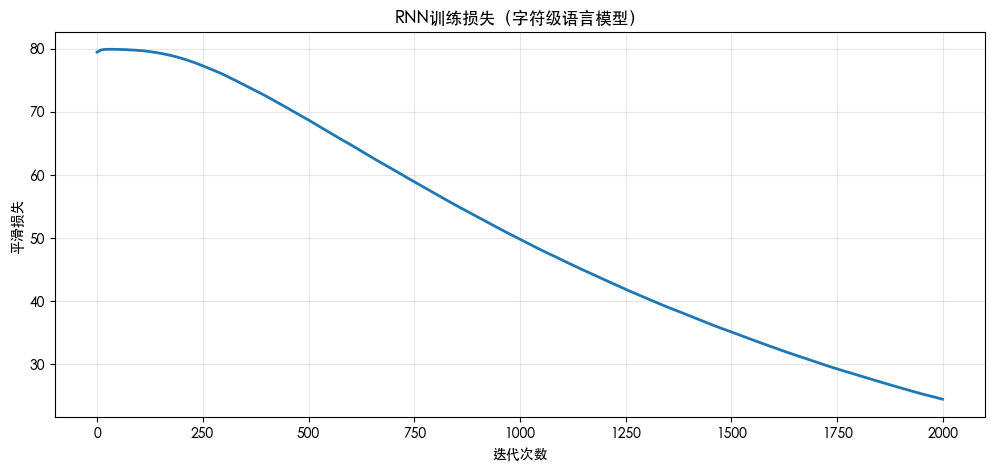

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('迭代次数')
plt.ylabel('平滑损失')
plt.title('RNN训练损失（字符级语言模型）')
plt.grid(True, alpha=0.3)
plt.show()

## 从训练好的模型生成文本

In [6]:
# 使用不同的种子生成样本
h = np.zeros((hidden_size, 1))

print("生成的样本:\n")
for i in range(5):
    seed_char = np.random.choice(chars)
    seed_ix = char_to_ix[seed_char]
    sample_ix = rnn.sample(h, seed_ix, 150)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print(f"样本 {i+1} (种子: '{seed_char}'):")
    print(txt)
    print()

生成的样本:

样本 1 (种子: 'n'):
o foom leerning
learningg
worexamas informationforioksing
heleks leura datto

hello worlddra  ehes eveurelp neuratdramrsmes
es lorld
hello work deep n

样本 2 (种子: 'h'):
eoo
leces
leuelloks
hele neal nete helees lea worocerywrhyro dheves learning dea everyorks
neueeles loom leural heres epllo delexs
help neueal overyhe

样本 3 (种子: 'h'):
eles neuramatterns
information pattworks
neural netwo wereces everks pri heueal neullo dral nearng
iris learning
fromes learnvarywhere
help dveryn del

样本 4 (种子: 'v'):
ern data
draves eerning lelworn intatfors eves nearn information forks in 
eptes
eves leureves exagrss promation ing
or delp nearng
frror
heles deernv

样本 5 (种子: 'x'):
ameuelens
learnin
dal orworkl nete nero deep networ data
data drives everywheerlo woro 
eates learninfdrawworks oratpess in patices learns promatacp p



## 可视化隐藏状态激活

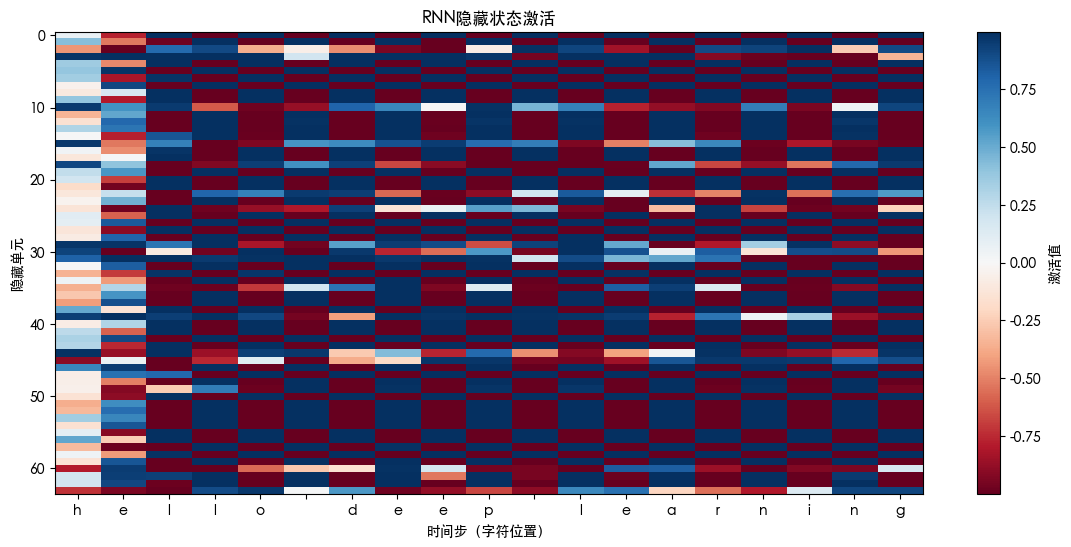


可视化显示了RNN处理 'hello deep learning' 时隐藏状态如何演化


In [7]:
# 通过序列的前向传播来可视化激活
test_text = "hello deep learning"
test_inputs = [char_to_ix[ch] for ch in test_text]
hprev = np.zeros((hidden_size, 1))

xs, hs, ys, ps = rnn.forward(test_inputs, hprev)

# 提取隐藏状态
hidden_states = np.array([hs[t].flatten() for t in range(len(test_inputs))])

plt.figure(figsize=(14, 6))
plt.imshow(hidden_states.T, cmap='RdBu', aspect='auto', interpolation='nearest')
plt.colorbar(label='激活值')
plt.xlabel('时间步（字符位置）')
plt.ylabel('隐藏单元')
plt.title('RNN隐藏状态激活')
plt.xticks(range(len(test_text)), list(test_text))
plt.show()

print(f"\n可视化显示了RNN处理 '{test_text}' 时隐藏状态如何演化")

## 关键要点

1. **字符级建模**：RNN可以学习逐字符生成文本
2. **循环连接**：隐藏状态在时间步之间传递信息
3. **通过时间反向传播**：梯度在序列中反向流动
4. **梯度裁剪**：对于防止梯度爆炸至关重要
5. **采样**：采样中的温度控制影响多样性

### 不合理有效性：
- 简单的RNN架构可以学习复杂的模式
- 无需显式的特征工程
- 自动学习层次化表示
- 泛化到未见过的字符组合